In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold
import lightgbm as lgb
from optiver_features import *

In [3]:
data_dir = Path('../input/optiver-realized-volatility-prediction')

## Generate 5m dataset

In [4]:
book_feature_dict = {
        wap1: [np.mean, np.std],
        wap2: [np.mean, np.std],
        log_return1: [realized_volatility, np.mean, np.std],
        log_return2: [realized_volatility, np.mean, np.std],
        wap_balance: [np.mean, np.std],
        price_spread:[np.mean, np.std],
        bid_spread: [np.mean, np.std],
        ask_spread:[np.mean, np.std],
        total_volume:[np.mean, np.std],
        volume_imbalance:[np.mean, np.std]
    }

In [5]:
trade_feature_dict = {
        log_return_price: [realized_volatility],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.mean],
    }

In [6]:
time_id_features=['log_return_price_realized_volatility_0_300',
 'log_return_price_realized_volatility_0_100',
 'log_return_price_realized_volatility_100_200',
 'log_return_price_realized_volatility_200_300',
 'log_return1_realized_volatility_0_300',
 'log_return2_realized_volatility_0_300',
 'log_return1_realized_volatility_0_100',
 'log_return2_realized_volatility_0_100',
 'log_return1_realized_volatility_100_200',
 'log_return2_realized_volatility_100_200',
 'log_return1_realized_volatility_200_300',
 'log_return2_realized_volatility_200_300']
time_id_aggregations = ['mean', 'std', 'max', 'min' ]
stock_id_features = time_id_features
stock_id_aggregations = time_id_aggregations

In [7]:
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [8]:
ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
train_df5m = ofg.generate_train_df()
ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
targ_df = ofg_targ.generate_train_df()
train_df5m.target = targ_df.log_return1_realized_volatility_300_600
train_df5m.to_csv('train_5m.csv', index=False)

In [28]:
train_df5m = pd.read_csv('train_5m.csv')

In [9]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

In [10]:
def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [11]:
train_df5_10m  = generate_5_to_10()
train_df5_10m.to_csv('train_5_10.csv', index=False)

In [ ]:
train_df5_10m =pd.read_csv('train_5_10.csv')

In [18]:
train_df5m.target = train_df5m.target.replace(0, train_df5m.target.mean())

## LGBM Baseline

In [30]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [42]:
_=train_models(train_df5m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000336206	training's RMSPE: 0.230114	valid_1's rmse: 0.000348266	valid_1's RMSPE: 0.237838
[200]	training's rmse: 0.000327093	training's RMSPE: 0.223876	valid_1's rmse: 0.000344473	valid_1's RMSPE: 0.235248
[300]	training's rmse: 0.00032084	training's RMSPE: 0.219596	valid_1's rmse: 0.000342844	valid_1's RMSPE: 0.234135
[400]	training's rmse: 0.00031613	training's RMSPE: 0.216373	valid_1's rmse: 0.000341808	valid_1's RMSPE: 0.233428
Early stopping, best iteration is:
[421]	training's rmse: 0.000315125	training's RMSPE: 0.215685	valid_1's rmse: 0.000341509	valid_1's RMSPE: 0.233224
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000334497	training's RMSPE: 0.229403	valid_1's rmse: 0.000359582	valid_1's RMSPE: 0.243576
[200]	training's rmse: 0.000325743	training's RMSPE: 0.2234	valid_1's rmse: 0.00035557	valid_1's RMSPE: 0.240858
[300]	training's rmse: 0.000319739	training's RMSPE: 0.219282	valid_1's rmse: 0.000352736	valid_1's RMSPE: 0.238939
[400]	training's rmse: 0.000315028	training's RMSPE: 0.216051	valid_1's rmse: 0.000350802	valid_1's RMSPE: 0.237629
Early stopping, best iteration is:
[436]	training's rmse: 0.000313388	training's RMSPE: 0.214926	valid_1's rmse: 0.000350114	valid_1's RMSPE: 0.237163
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000337645	training's RMSPE: 0.229226	valid_1's rmse: 0.000354815	valid_1's RMSPE: 0.250041
[200]	training's rmse: 0.000328279	training's RMSPE: 0.222868	valid_1's rmse: 0.000349156	valid_1's RMSPE: 0.246053
[300]	training's rmse: 0.000322277	training's RMSPE: 0.218793	valid_1's rmse: 0.000347756	valid_1's RMSPE: 0.245067
Early stopping, best iteration is:
[280]	training's rmse: 0.000323415	training's RMSPE: 0.219566	valid_1's rmse: 0.000346992	valid_1's RMSPE: 0.244528
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000336877	training's RMSPE: 0.230437	valid_1's rmse: 0.000350868	valid_1's RMSPE: 0.240181
[200]	training's rmse: 0.000327065	training's RMSPE: 0.223725	valid_1's rmse: 0.000345667	valid_1's RMSPE: 0.23662
[300]	training's rmse: 0.000320848	training's RMSPE: 0.219473	valid_1's rmse: 0.000343531	valid_1's RMSPE: 0.235158
Early stopping, best iteration is:
[340]	training's rmse: 0.000318877	training's RMSPE: 0.218124	valid_1's rmse: 0.000342698	valid_1's RMSPE: 0.234588
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00033545	training's RMSPE: 0.23061	valid_1's rmse: 0.000352896	valid_1's RMSPE: 0.236675
[200]	training's rmse: 0.000325772	training's RMSPE: 0.223957	valid_1's rmse: 0.000348559	valid_1's RMSPE: 0.233766
[300]	training's rmse: 0.00031941	training's RMSPE: 0.219583	valid_1's rmse: 0.000345763	valid_1's RMSPE: 0.231891
[400]	training's rmse: 0.000314477	training's RMSPE: 0.216192	valid_1's rmse: 0.000343946	valid_1's RMSPE: 0.230673
[500]	training's rmse: 0.000310398	training's RMSPE: 0.213388	valid_1's rmse: 0.000342762	valid_1's RMSPE: 0.229878
Early stopping, best iteration is:
[522]	training's rmse: 0.000309546	training's RMSPE: 0.212802	valid_1's rmse: 0.000342613	valid_1's RMSPE: 0.229779
Our out of folds RMSPE is 0.23590818890027127


## Learning embeddings

In [19]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')


cat_nn = ['time_id', 'stock_id']

In [20]:

procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter()(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

In [21]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':.25, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[100,50,20], emb_szs={'stock_id':10, 'time_id':10}, 
                        n_out=1, loss_func = rmspe, metrics=AccumMetric(rmspe), config=config)

In [22]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,10.813059,8.840131,8.849628,00:05
1,1.479396,0.955893,0.963897,00:05
2,0.369061,0.279955,0.280443,00:05
3,0.291158,0.255349,0.255608,00:05
4,0.277610,0.245956,0.258092,00:05
5,0.260917,0.251597,0.253497,00:05
6,0.339435,0.239001,0.239337,00:05
7,0.254844,0.236721,0.241665,00:05
8,0.252927,0.253697,0.305805,00:05
9,0.256701,0.234285,0.235019,00:05


In [23]:
torch.save(learn.model.embeds[0].weight.data, 'timeemb10.pt')

In [24]:
categorify = dls.procs[2]
len(categorify.classes['time_id'])

3831

In [25]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs.weight[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs.weight[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.weight.shape[1])] +[f'time_emb{i}' for i in range(time_embs.weight.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [26]:
train_with_embs = append_embs(train_df5m, categorify, learn.model.embeds[0], learn.model.embeds[1])



In [28]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [31]:
_=train_models(train_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000321977	training's RMSPE: 0.220374	valid_1's rmse: 0.000331336	valid_1's RMSPE: 0.226277
[200]	training's rmse: 0.000312665	training's RMSPE: 0.214001	valid_1's rmse: 0.000326803	valid_1's RMSPE: 0.223181
[300]	training's rmse: 0.00030704	training's RMSPE: 0.210151	valid_1's rmse: 0.000325186	valid_1's RMSPE: 0.222077
[400]	training's rmse: 0.000303422	training's RMSPE: 0.207675	valid_1's rmse: 0.000324353	valid_1's RMSPE: 0.221508
Early stopping, best iteration is:
[463]	training's rmse: 0.000301309	training's RMSPE: 0.206228	valid_1's rmse: 0.000323981	valid_1's RMSPE: 0.221253
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000320615	training's RMSPE: 0.219883	valid_1's rmse: 0.00034377	valid_1's RMSPE: 0.232865
[200]	training's rmse: 0.000311709	training's RMSPE: 0.213775	valid_1's rmse: 0.000339264	valid_1's RMSPE: 0.229813
[300]	training's rmse: 0.000306363	training's RMSPE: 0.210108	valid_1's rmse: 0.000336754	valid_1's RMSPE: 0.228112
[400]	training's rmse: 0.000302452	training's RMSPE: 0.207426	valid_1's rmse: 0.000335648	valid_1's RMSPE: 0.227363
Early stopping, best iteration is:
[439]	training's rmse: 0.000301141	training's RMSPE: 0.206527	valid_1's rmse: 0.000335372	valid_1's RMSPE: 0.227177
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000322864	training's RMSPE: 0.219192	valid_1's rmse: 0.000344273	valid_1's RMSPE: 0.242612
Early stopping, best iteration is:
[170]	training's rmse: 0.000315715	training's RMSPE: 0.214338	valid_1's rmse: 0.000339777	valid_1's RMSPE: 0.239444
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000322004	training's RMSPE: 0.220263	valid_1's rmse: 0.000334451	valid_1's RMSPE: 0.228943
[200]	training's rmse: 0.000312484	training's RMSPE: 0.213751	valid_1's rmse: 0.000329	valid_1's RMSPE: 0.225211
[300]	training's rmse: 0.000307268	training's RMSPE: 0.210184	valid_1's rmse: 0.00032714	valid_1's RMSPE: 0.223938
Early stopping, best iteration is:
[338]	training's rmse: 0.000305641	training's RMSPE: 0.209071	valid_1's rmse: 0.000326295	valid_1's RMSPE: 0.22336
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000320115	training's RMSPE: 0.220068	valid_1's rmse: 0.000336395	valid_1's RMSPE: 0.225608
[200]	training's rmse: 0.000310636	training's RMSPE: 0.213551	valid_1's rmse: 0.000331348	valid_1's RMSPE: 0.222223
[300]	training's rmse: 0.000305191	training's RMSPE: 0.209808	valid_1's rmse: 0.000329298	valid_1's RMSPE: 0.220849
[400]	training's rmse: 0.000301162	training's RMSPE: 0.207038	valid_1's rmse: 0.000328223	valid_1's RMSPE: 0.220128
[500]	training's rmse: 0.00029803	training's RMSPE: 0.204885	valid_1's rmse: 0.000327751	valid_1's RMSPE: 0.219811
[600]	training's rmse: 0.00029515	training's RMSPE: 0.202906	valid_1's rmse: 0.000327357	valid_1's RMSPE: 0.219547
Early stopping, best iteration is:
[648]	training's rmse: 0.000293863	training's RMSPE: 0.202021	valid_1's rmse: 0.000327181	valid_1's RMSPE: 0.219429
Our out of folds RMSPE is 0.22624504800360667


## Baseline LGMB 10m

In [34]:
time_windows = [(0,600), (0,100), (100,200), (200,300), (300,400), (400,500), (500,600)]

In [36]:
cols = ['log_return_price_realized_volatility', 'log_return1_realized_volatility']

In [39]:
time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in cols] 
time_id_aggregations = ['mean', 'std', 'max', 'min' ]
stock_id_features = time_id_features
stock_id_aggregations = time_id_aggregations

In [41]:
ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
train_df10m = ofg.generate_train_df()

In [42]:
train_df10m

,stock_id,time_id,target,row_id,seconds_in_bucket_size_0_600,size_sum_0_600,order_count_mean_0_600,log_return_price_realized_volatility_0_600,seconds_in_bucket_size_0_100,size_sum_0_100,...,log_return1_realized_volatility_400_500_max_time,log_return1_realized_volatility_400_500_min_time,log_return_price_realized_volatility_500_600_mean_time,log_return_price_realized_volatility_500_600_std_time,log_return_price_realized_volatility_500_600_max_time,log_return_price_realized_volatility_500_600_min_time,log_return1_realized_volatility_500_600_mean_time,log_return1_realized_volatility_500_600_std_time,log_return1_realized_volatility_500_600_max_time,log_return1_realized_volatility_500_600_min_time
0,0,5,0.004136,0-5,40.0,3179.0,2.750000,0.002006,6.0,768.0,...,0.004686,0.000426,0.001066,0.000431,0.002841,0.000013,0.001728,0.000950,0.007466,0.000411
1,0,11,0.001445,0-11,30.0,1289.0,1.900000,0.000901,5.0,115.0,...,0.002603,0.000036,0.000476,0.000306,0.002636,0.000000,0.000802,0.000504,0.003575,0.000133
2,0,16,0.002168,0-16,25.0,2161.0,2.720000,0.001961,2.0,129.0,...,0.002667,0.000013,0.000634,0.000301,0.001923,0.000114,0.000925,0.000371,0.002453,0.000302
3,0,31,0.002195,0-31,15.0,1962.0,3.933333,0.001561,2.0,29.0,...,0.003008,0.000108,0.000563,0.000440,0.003327,0.000000,0.000948,0.000547,0.002835,0.000163
4,0,62,0.001747,0-62,22.0,1791.0,4.045455,0.000871,4.0,217.0,...,0.002211,0.000087,0.000438,0.000267,0.001816,0.000000,0.000764,0.000469,0.002469,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,37.0,2570.0,2.783784,0.002171,8.0,1138.0,...,0.003634,0.000251,0.000735,0.000307,0.002456,0.000000,0.001210,0.000579,0.003971,0.000293
428928,126,32753,0.003113,126-32753,43.0,2323.0,3.418605,0.002180,5.0,405.0,...,0.005581,0.000003,0.000522,0.000340,0.002413,0.000000,0.000795,0.000560,0.003772,0.000066
428929,126,32758,0.004070,126-32758,35.0,3740.0,2.800000,0.001921,1.0,105.0,...,0.002943,0.000172,0.000596,0.000285,0.001461,0.000000,0.000945,0.000441,0.002202,0.000262
428930,126,32763,0.003357,126-32763,80.0,9389.0,2.925000,0.002051,10.0,1076.0,...,0.003772,0.000386,0.000859,0.000376,0.002417,0.000000,0.001276,0.000653,0.003824,0.000328


In [43]:
train_df10m.to_csv('train_10m.csv')

In [44]:
_=train_models(train_df10m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.0004681	training's RMSPE: 0.21672	valid_1's rmse: 0.000478425	valid_1's RMSPE: 0.221103
[200]	training's rmse: 0.00045131	training's RMSPE: 0.208947	valid_1's rmse: 0.000465244	valid_1's RMSPE: 0.215011
[300]	training's rmse: 0.00044067	training's RMSPE: 0.204021	valid_1's rmse: 0.000457416	valid_1's RMSPE: 0.211393
[400]	training's rmse: 0.000431289	training's RMSPE: 0.199678	valid_1's rmse: 0.000451045	valid_1's RMSPE: 0.208449
[500]	training's rmse: 0.000423815	training's RMSPE: 0.196217	valid_1's rmse: 0.000445772	valid_1's RMSPE: 0.206012
[600]	training's rmse: 0.00041749	training's RMSPE: 0.193289	valid_1's rmse: 0.000441969	valid_1's RMSPE: 0.204255
[700]	training's rmse: 0.000410987	training's RMSPE: 0.190278	valid_1's rmse: 0.000437877	valid_1's RMSPE: 0.202364
[800]	training's rmse: 0.000406037	training's RMSPE: 0.187987	valid_1's rmse: 0.000435362	valid_1's RMSPE: 0.201201
[900]	training's 

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000470718	training's RMSPE: 0.217706	valid_1's rmse: 0.000489113	valid_1's RMSPE: 0.226982
[200]	training's rmse: 0.000454326	training's RMSPE: 0.210125	valid_1's rmse: 0.000476942	valid_1's RMSPE: 0.221334
[300]	training's rmse: 0.000442971	training's RMSPE: 0.204873	valid_1's rmse: 0.000469089	valid_1's RMSPE: 0.21769
[400]	training's rmse: 0.000432688	training's RMSPE: 0.200117	valid_1's rmse: 0.000462898	valid_1's RMSPE: 0.214816
[500]	training's rmse: 0.000424882	training's RMSPE: 0.196507	valid_1's rmse: 0.000457475	valid_1's RMSPE: 0.2123
Early stopping, best iteration is:
[546]	training's rmse: 0.000421904	training's RMSPE: 0.19513	valid_1's rmse: 0.000455843	valid_1's RMSPE: 0.211542
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467473	training's RMSPE: 0.216451	valid_1's rmse: 0.000474465	valid_1's RMSPE: 0.219188
[200]	training's rmse: 0.000451249	training's RMSPE: 0.208939	valid_1's rmse: 0.000461461	valid_1's RMSPE: 0.213181
[300]	training's rmse: 0.00044066	training's RMSPE: 0.204036	valid_1's rmse: 0.000453675	valid_1's RMSPE: 0.209584
[400]	training's rmse: 0.000431422	training's RMSPE: 0.199758	valid_1's rmse: 0.000447128	valid_1's RMSPE: 0.206559
[500]	training's rmse: 0.000423512	training's RMSPE: 0.196096	valid_1's rmse: 0.000441314	valid_1's RMSPE: 0.203874
[600]	training's rmse: 0.000416863	training's RMSPE: 0.193017	valid_1's rmse: 0.000437296	valid_1's RMSPE: 0.202018
[700]	training's rmse: 0.00041145	training's RMSPE: 0.190511	valid_1's rmse: 0.000434473	valid_1's RMSPE: 0.200713
[800]	training's rmse: 0.000406816	training's RMSPE: 0.188365	valid_1's rmse: 0.000432023	valid_1's RMSPE: 0.199582
[900]	trainin

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000469214	training's RMSPE: 0.216886	valid_1's rmse: 0.00047512	valid_1's RMSPE: 0.220992
[200]	training's rmse: 0.000453081	training's RMSPE: 0.209428	valid_1's rmse: 0.000463667	valid_1's RMSPE: 0.215665
[300]	training's rmse: 0.000441357	training's RMSPE: 0.204009	valid_1's rmse: 0.00045627	valid_1's RMSPE: 0.212224
[400]	training's rmse: 0.000431577	training's RMSPE: 0.199489	valid_1's rmse: 0.000449827	valid_1's RMSPE: 0.209228
[500]	training's rmse: 0.000424081	training's RMSPE: 0.196024	valid_1's rmse: 0.000445424	valid_1's RMSPE: 0.20718
[600]	training's rmse: 0.000417743	training's RMSPE: 0.193094	valid_1's rmse: 0.000442064	valid_1's RMSPE: 0.205617
[700]	training's rmse: 0.000411916	training's RMSPE: 0.1904	valid_1's rmse: 0.000439013	valid_1's RMSPE: 0.204198
[800]	training's rmse: 0.000407238	training's RMSPE: 0.188238	valid_1's rmse: 0.000437326	valid_1's RMSPE: 0.203413
[900]	training's

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467712	training's RMSPE: 0.216705	valid_1's rmse: 0.000479267	valid_1's RMSPE: 0.220815
[200]	training's rmse: 0.000451234	training's RMSPE: 0.209071	valid_1's rmse: 0.000466372	valid_1's RMSPE: 0.214874
[300]	training's rmse: 0.000439878	training's RMSPE: 0.203809	valid_1's rmse: 0.00045851	valid_1's RMSPE: 0.211252
[400]	training's rmse: 0.00043088	training's RMSPE: 0.19964	valid_1's rmse: 0.000451811	valid_1's RMSPE: 0.208165
[500]	training's rmse: 0.000423856	training's RMSPE: 0.196385	valid_1's rmse: 0.000447868	valid_1's RMSPE: 0.206349
[600]	training's rmse: 0.000416625	training's RMSPE: 0.193035	valid_1's rmse: 0.000443584	valid_1's RMSPE: 0.204375
[700]	training's rmse: 0.000410778	training's RMSPE: 0.190326	valid_1's rmse: 0.000439899	valid_1's RMSPE: 0.202677
[800]	training's rmse: 0.000406206	training's RMSPE: 0.188208	valid_1's rmse: 0.000437816	valid_1's RMSPE: 0.201718
Early stopping

## LGBM 10m with trained embeddings

In [64]:
train_df10m = pd.read_csv('train_10m.csv')

In [50]:
train_10m_with_embs = append_embs(train_df10m, categorify, learn.model.embeds[0], learn.model.embeds[1])

In [51]:
train_10m_with_embs

,stock_id,time_id,target,row_id,seconds_in_bucket_size_0_600,size_sum_0_600,order_count_mean_0_600,log_return_price_realized_volatility_0_600,seconds_in_bucket_size_0_100,size_sum_0_100,...,time_emb0,time_emb1,time_emb2,time_emb3,time_emb4,time_emb5,time_emb6,time_emb7,time_emb8,time_emb9
0,0,5,0.004136,0-5,40.0,3179.0,2.750000,0.002006,6.0,768.0,...,-0.025587,-0.137472,0.139260,-0.050806,-0.261243,-0.194197,-0.174686,-0.182866,-0.082646,-0.002412
1,0,11,0.001445,0-11,30.0,1289.0,1.900000,0.000901,5.0,115.0,...,0.081401,0.285139,0.068592,0.016952,0.256820,0.200299,-0.002330,0.050801,-0.020215,-0.006541
2,0,16,0.002168,0-16,25.0,2161.0,2.720000,0.001961,2.0,129.0,...,-0.312756,0.124296,0.195272,-0.350742,-0.224611,0.478563,-0.144404,0.339522,0.324518,-0.310829
3,0,31,0.002195,0-31,15.0,1962.0,3.933333,0.001561,2.0,29.0,...,-0.269838,-0.255659,0.240358,-0.140966,-0.218252,-0.013182,-0.215490,-0.150979,-0.016923,-0.146056
4,0,62,0.001747,0-62,22.0,1791.0,4.045455,0.000871,4.0,217.0,...,-0.281641,-0.334068,0.042509,-0.181932,-0.175953,-0.018926,-0.179612,0.026053,0.214317,-0.205210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,126,32751,0.003461,126-32751,37.0,2570.0,2.783784,0.002171,8.0,1138.0,...,-0.214146,-0.254524,0.220342,-0.309527,-0.240333,0.517282,-0.312113,0.266440,0.463562,-0.493132
428928,126,32753,0.003113,126-32753,43.0,2323.0,3.418605,0.002180,5.0,405.0,...,-0.123949,-0.180638,0.099670,-0.155571,-0.067919,0.146707,-0.114577,-0.031359,0.078393,-0.090751
428929,126,32758,0.004070,126-32758,35.0,3740.0,2.800000,0.001921,1.0,105.0,...,-0.320554,0.052518,0.175992,-0.195550,-0.225560,0.317942,-0.339985,0.360710,0.199884,-0.344039
428930,126,32763,0.003357,126-32763,80.0,9389.0,2.925000,0.002051,10.0,1076.0,...,-0.247623,-0.257361,0.087669,-0.013017,-0.103501,-0.415510,-0.224490,-0.326946,0.050746,-0.040909


In [52]:
_=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000466976	training's RMSPE: 0.2162	valid_1's rmse: 0.000478618	valid_1's RMSPE: 0.221192
[200]	training's rmse: 0.000449878	training's RMSPE: 0.208284	valid_1's rmse: 0.000465269	valid_1's RMSPE: 0.215023
[300]	training's rmse: 0.000439213	training's RMSPE: 0.203346	valid_1's rmse: 0.000457525	valid_1's RMSPE: 0.211444
[400]	training's rmse: 0.000429675	training's RMSPE: 0.19893	valid_1's rmse: 0.000450747	valid_1's RMSPE: 0.208312
[500]	training's rmse: 0.000422779	training's RMSPE: 0.195738	valid_1's rmse: 0.000446229	valid_1's RMSPE: 0.206224
[600]	training's rmse: 0.000416129	training's RMSPE: 0.192659	valid_1's rmse: 0.000441965	valid_1's RMSPE: 0.204253
[700]	training's rmse: 0.000410219	training's RMSPE: 0.189923	valid_1's rmse: 0.000438085	valid_1's RMSPE: 0.20246
[800]	training's rmse: 0.000405281	training's RMSPE: 0.187637	valid_1's rmse: 0.000435558	valid_1's RMSPE: 0.201292
[900]	training'

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468851	training's RMSPE: 0.216843	valid_1's rmse: 0.000486691	valid_1's RMSPE: 0.225858
[200]	training's rmse: 0.000451998	training's RMSPE: 0.209048	valid_1's rmse: 0.000474182	valid_1's RMSPE: 0.220053
[300]	training's rmse: 0.000439961	training's RMSPE: 0.203481	valid_1's rmse: 0.000466721	valid_1's RMSPE: 0.216591
[400]	training's rmse: 0.000430863	training's RMSPE: 0.199273	valid_1's rmse: 0.000462447	valid_1's RMSPE: 0.214607
[500]	training's rmse: 0.000422491	training's RMSPE: 0.195401	valid_1's rmse: 0.000455444	valid_1's RMSPE: 0.211357
[600]	training's rmse: 0.000416379	training's RMSPE: 0.192575	valid_1's rmse: 0.000452775	valid_1's RMSPE: 0.210119
[700]	training's rmse: 0.000410778	training's RMSPE: 0.189984	valid_1's rmse: 0.000451184	valid_1's RMSPE: 0.20938
[800]	training's rmse: 0.000405888	training's RMSPE: 0.187723	valid_1's rmse: 0.000449027	valid_1's RMSPE: 0.208379
[900]	traini

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00046643	training's RMSPE: 0.215968	valid_1's rmse: 0.000473862	valid_1's RMSPE: 0.21891
[200]	training's rmse: 0.000450343	training's RMSPE: 0.208519	valid_1's rmse: 0.000460889	valid_1's RMSPE: 0.212916
[300]	training's rmse: 0.000439107	training's RMSPE: 0.203317	valid_1's rmse: 0.000452435	valid_1's RMSPE: 0.209011
[400]	training's rmse: 0.000430629	training's RMSPE: 0.199391	valid_1's rmse: 0.000446569	valid_1's RMSPE: 0.206301
[500]	training's rmse: 0.000422673	training's RMSPE: 0.195708	valid_1's rmse: 0.00044085	valid_1's RMSPE: 0.203659
[600]	training's rmse: 0.000415906	training's RMSPE: 0.192574	valid_1's rmse: 0.000436613	valid_1's RMSPE: 0.201702
[700]	training's rmse: 0.000409978	training's RMSPE: 0.189829	valid_1's rmse: 0.000433443	valid_1's RMSPE: 0.200237
[800]	training's rmse: 0.000405343	training's RMSPE: 0.187683	valid_1's rmse: 0.000431064	valid_1's RMSPE: 0.199138
[900]	training

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467468	training's RMSPE: 0.216078	valid_1's rmse: 0.000473692	valid_1's RMSPE: 0.220328
[200]	training's rmse: 0.00045106	training's RMSPE: 0.208494	valid_1's rmse: 0.000462226	valid_1's RMSPE: 0.214995
[300]	training's rmse: 0.000439179	training's RMSPE: 0.203003	valid_1's rmse: 0.000454122	valid_1's RMSPE: 0.211226
[400]	training's rmse: 0.000429945	training's RMSPE: 0.198734	valid_1's rmse: 0.000448516	valid_1's RMSPE: 0.208618
[500]	training's rmse: 0.000421967	training's RMSPE: 0.195047	valid_1's rmse: 0.000443849	valid_1's RMSPE: 0.206447
[600]	training's rmse: 0.000415446	training's RMSPE: 0.192033	valid_1's rmse: 0.000440452	valid_1's RMSPE: 0.204867
[700]	training's rmse: 0.000409926	training's RMSPE: 0.189481	valid_1's rmse: 0.00043744	valid_1's RMSPE: 0.203466
[800]	training's rmse: 0.000404702	training's RMSPE: 0.187066	valid_1's rmse: 0.000435131	valid_1's RMSPE: 0.202392
[900]	trainin

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000465672	training's RMSPE: 0.21576	valid_1's rmse: 0.000478286	valid_1's RMSPE: 0.220363
[200]	training's rmse: 0.000449611	training's RMSPE: 0.208319	valid_1's rmse: 0.000465522	valid_1's RMSPE: 0.214483
[300]	training's rmse: 0.000437627	training's RMSPE: 0.202766	valid_1's rmse: 0.000456411	valid_1's RMSPE: 0.210285
[400]	training's rmse: 0.000428682	training's RMSPE: 0.198621	valid_1's rmse: 0.000449903	valid_1's RMSPE: 0.207286
[500]	training's rmse: 0.000421123	training's RMSPE: 0.195119	valid_1's rmse: 0.000445156	valid_1's RMSPE: 0.205099
[600]	training's rmse: 0.000414616	training's RMSPE: 0.192104	valid_1's rmse: 0.000441091	valid_1's RMSPE: 0.203226
[700]	training's rmse: 0.000408701	training's RMSPE: 0.189364	valid_1's rmse: 0.000437846	valid_1's RMSPE: 0.201731
[800]	training's rmse: 0.000404144	training's RMSPE: 0.187252	valid_1's rmse: 0.00043549	valid_1's RMSPE: 0.200646
Early stoppin

### 2012 -> 1991

## LGBM with embeddings and time/stock features and 5-10

In [53]:
train_10m_with_embs['5m_pred']=preds5_10

In [54]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000464032	training's RMSPE: 0.214837	valid_1's rmse: 0.000473087	valid_1's RMSPE: 0.218636
[200]	training's rmse: 0.000446797	training's RMSPE: 0.206857	valid_1's rmse: 0.000460003	valid_1's RMSPE: 0.212589
[300]	training's rmse: 0.000435551	training's RMSPE: 0.201651	valid_1's rmse: 0.00045253	valid_1's RMSPE: 0.209136
[400]	training's rmse: 0.000426807	training's RMSPE: 0.197603	valid_1's rmse: 0.000447276	valid_1's RMSPE: 0.206707
[500]	training's rmse: 0.000419809	training's RMSPE: 0.194363	valid_1's rmse: 0.000442906	valid_1's RMSPE: 0.204688
[600]	training's rmse: 0.000413183	training's RMSPE: 0.191295	valid_1's rmse: 0.000438863	valid_1's RMSPE: 0.202819
[700]	training's rmse: 0.000407391	training's RMSPE: 0.188613	valid_1's rmse: 0.000435782	valid_1's RMSPE: 0.201396
[800]	training's rmse: 0.0004026	training's RMSPE: 0.186395	valid_1's rmse: 0.00043311	valid_1's RMSPE: 0.200161
[900]	training'

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000465066	training's RMSPE: 0.215092	valid_1's rmse: 0.000477534	valid_1's RMSPE: 0.221608
[200]	training's rmse: 0.000449472	training's RMSPE: 0.20788	valid_1's rmse: 0.000467205	valid_1's RMSPE: 0.216815
[300]	training's rmse: 0.000437461	training's RMSPE: 0.202325	valid_1's rmse: 0.00045968	valid_1's RMSPE: 0.213323
[400]	training's rmse: 0.000429014	training's RMSPE: 0.198418	valid_1's rmse: 0.000455283	valid_1's RMSPE: 0.211283
[500]	training's rmse: 0.000421484	training's RMSPE: 0.194936	valid_1's rmse: 0.00045137	valid_1's RMSPE: 0.209467
[600]	training's rmse: 0.000415251	training's RMSPE: 0.192053	valid_1's rmse: 0.000449027	valid_1's RMSPE: 0.208379
Early stopping, best iteration is:
[674]	training's rmse: 0.00041094	training's RMSPE: 0.190059	valid_1's rmse: 0.000447239	valid_1's RMSPE: 0.20755
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000463562	training's RMSPE: 0.21464	valid_1's rmse: 0.000470231	valid_1's RMSPE: 0.217232
[200]	training's rmse: 0.000447234	training's RMSPE: 0.20708	valid_1's rmse: 0.000456978	valid_1's RMSPE: 0.21111
[300]	training's rmse: 0.000436524	training's RMSPE: 0.202121	valid_1's rmse: 0.000449098	valid_1's RMSPE: 0.20747
[400]	training's rmse: 0.000428338	training's RMSPE: 0.198331	valid_1's rmse: 0.00044385	valid_1's RMSPE: 0.205045
[500]	training's rmse: 0.000420927	training's RMSPE: 0.194899	valid_1's rmse: 0.000438639	valid_1's RMSPE: 0.202638
[600]	training's rmse: 0.000414186	training's RMSPE: 0.191778	valid_1's rmse: 0.000434197	valid_1's RMSPE: 0.200586
[700]	training's rmse: 0.000409081	training's RMSPE: 0.189414	valid_1's rmse: 0.00043171	valid_1's RMSPE: 0.199437
[800]	training's rmse: 0.000403976	training's RMSPE: 0.18705	valid_1's rmse: 0.000428837	valid_1's RMSPE: 0.198109
[900]	training's r

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000463942	training's RMSPE: 0.214449	valid_1's rmse: 0.000468745	valid_1's RMSPE: 0.218027
[200]	training's rmse: 0.000448266	training's RMSPE: 0.207203	valid_1's rmse: 0.000457003	valid_1's RMSPE: 0.212565
[300]	training's rmse: 0.00043705	training's RMSPE: 0.202018	valid_1's rmse: 0.000449842	valid_1's RMSPE: 0.209235
[400]	training's rmse: 0.000428117	training's RMSPE: 0.197889	valid_1's rmse: 0.000444145	valid_1's RMSPE: 0.206585
[500]	training's rmse: 0.000420788	training's RMSPE: 0.194501	valid_1's rmse: 0.000440404	valid_1's RMSPE: 0.204845
[600]	training's rmse: 0.000414831	training's RMSPE: 0.191748	valid_1's rmse: 0.000437181	valid_1's RMSPE: 0.203346
[700]	training's rmse: 0.000409199	training's RMSPE: 0.189145	valid_1's rmse: 0.00043475	valid_1's RMSPE: 0.202215
[800]	training's rmse: 0.00040444	training's RMSPE: 0.186945	valid_1's rmse: 0.00043301	valid_1's RMSPE: 0.201406
[900]	training'

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000462526	training's RMSPE: 0.214303	valid_1's rmse: 0.00047294	valid_1's RMSPE: 0.2179
[200]	training's rmse: 0.000446701	training's RMSPE: 0.20697	valid_1's rmse: 0.000460683	valid_1's RMSPE: 0.212253
[300]	training's rmse: 0.000435136	training's RMSPE: 0.201612	valid_1's rmse: 0.000453269	valid_1's RMSPE: 0.208837
[400]	training's rmse: 0.000426285	training's RMSPE: 0.197511	valid_1's rmse: 0.000448257	valid_1's RMSPE: 0.206528
[500]	training's rmse: 0.000419045	training's RMSPE: 0.194156	valid_1's rmse: 0.000444854	valid_1's RMSPE: 0.20496
[600]	training's rmse: 0.000413312	training's RMSPE: 0.1915	valid_1's rmse: 0.000442131	valid_1's RMSPE: 0.203706
[700]	training's rmse: 0.000407651	training's RMSPE: 0.188877	valid_1's rmse: 0.000439336	valid_1's RMSPE: 0.202418
[800]	training's rmse: 0.00040256	training's RMSPE: 0.186518	valid_1's rmse: 0.00043685	valid_1's RMSPE: 0.201272
[900]	training's rms

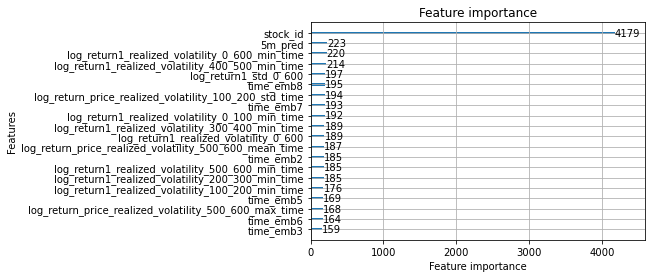

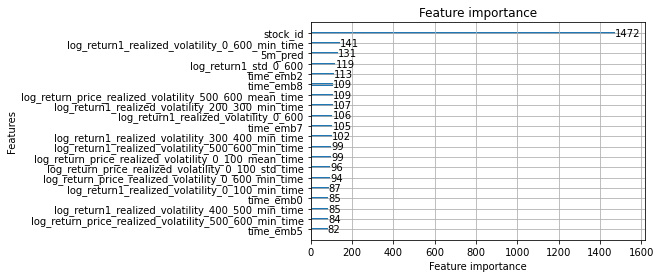

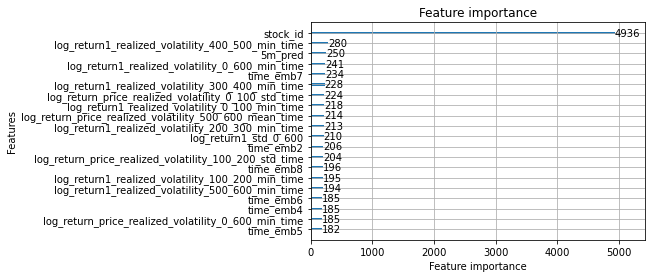

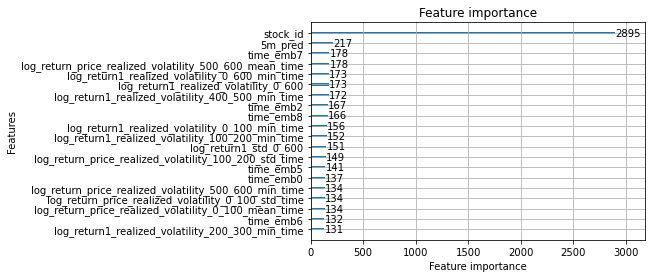

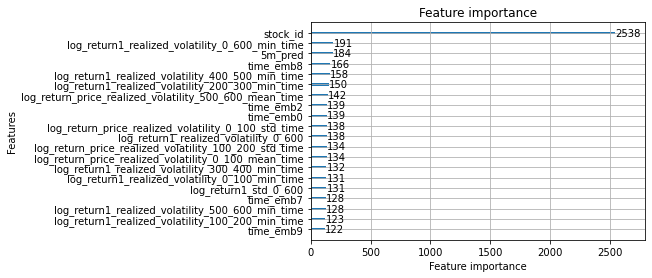

In [58]:
for m in models:
    lgb.plot_importance(m, max_num_features=20)

In [60]:
%%time
train_10m_with_embs.to_csv('train_with_embs_and_5m.csv', index=False)

CPU times: user 1min 35s, sys: 936 ms, total: 1min 36s
Wall time: 1min 39s


In [62]:
%%time
train_10m_with_embs.to_feather('train_with_embs_and_5m.feather')

CPU times: user 1.43 s, sys: 416 ms, total: 1.84 s
Wall time: 8.57 s


In [63]:
%%time
_=pd.read_feather('train_with_embs_and_5m.feather')

CPU times: user 851 ms, sys: 1.06 s, total: 1.91 s
Wall time: 270 ms


0         40.0
1         30.0
2         25.0
3         15.0
4         22.0
          ... 
428927    37.0
428928    43.0
428929    35.0
428930    80.0
428931    36.0
Name: seconds_in_bucket_size_0_600, Length: 428932, dtype: float64

In [78]:
train_10m_with_embs.seconds_in_bucket_size_0_600

0         40.0
1         30.0
2         25.0
3         15.0
4         22.0
          ... 
428927    37.0
428928    43.0
428929    35.0
428930    80.0
428931    36.0
Name: seconds_in_bucket_size_0_600, Length: 428932, dtype: float64